In [10]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, SimpleRNN, Conv2D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from matplotlib import image
import matplotlib.pyplot as plt
import os
import numpy as np

In [11]:
def getEmotion (file, file_emotion):
    if (file.endswith('.wav')):
        file_path.append(file)
        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

In [12]:
os.chdir('/Users/zeyuanli/Dropbox/Github/Librosa test'+'/AudioWAV')
audioFiles = os.listdir()
i = 1
mfcc_loaded = []
file_emotion = []
file_path = []

for audio in audioFiles:
    if audio.endswith('.wav'):
      if i % 500 == 0:
        print(i)
      i+=1
      result = np.array([])
      audioName = audio.split(".")[0]
      signal, sr = librosa.load(f"{audio}",offset = 0.3, duration = 2)
#      mfcc_loaded.append(librosa.feature.tempogram(y=signal, sr=sr).T)
 #     temp.append(librosa.feature.mfcc(y=signal,sr=sr).T)

      #tempo = np.mean(librosa.feature.tempogram(y=signal, sr=sr).T, axis=0)
      #getEmotion (audio, file_emotion)
      mfcc  = librosa.feature.melspectrogram(y=signal,sr=sr).T
      #getEmotion (audio, file_emotion)
      #chroma_stft  = np.mean(librosa.feature.chroma_stft(y=signal, sr= sr).T, axis =0)
      getEmotion (audio, file_emotion)
      #result = temp
      #result = np.vstack((result,mfcc))
      #result =np.vstack((result, tempo)) # stacking horizontally
      mfcc_loaded.append(mfcc)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Crema_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


,Emotions,Path
0,angry,1022_ITS_ANG_XX.wav
1,angry,1037_ITS_ANG_XX.wav
2,neutral,1060_ITS_NEU_XX.wav
3,neutral,1075_ITS_NEU_XX.wav
4,disgust,1073_IOM_DIS_XX.wav


In [32]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    #X = librosa.stft(data)'
    X = data
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Mel Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

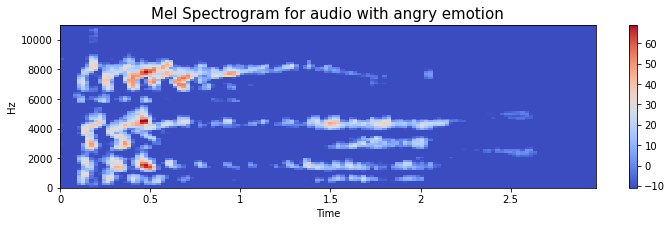

In [33]:
create_spectrogram (mfcc_loaded[0],22050, emotion_df.Emotions[0])

In [34]:
X = tf.keras.preprocessing.sequence.pad_sequences(mfcc_loaded)
X.shape
Y = np.array(data_path.Emotions)
encoder = OneHotEncoder()
Y = encoder.fit_transform(Y.reshape(-1,1)).toarray()

# making our data compatible to model.
#X = np.expand_dims(X, axis=-1)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.3)

In [36]:
print((X_train.shape))
print (y_train.shape)

(5209, 87, 128)
(5209, 6)


In [43]:
def LSTM_Model():
    
    model = tf.keras.Sequential()
    #model.add(SimpleRNN(128, input_shape=images_loaded[0], return_sequences=True))
    #model.add(Conv2D(256, kernel_size = (5,5), strides = 1,  padding = 'same', activation = 'relu', input_shape = (216,20,1)))
    model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

    model.summary()
    return model


In [44]:
model = LSTM_Model()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 87, 128)           131584    
_________________________________________________________________
dropout_6 (Dropout)          (None, 87, 128)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 271,814
Trainable params: 271,814
Non-trainable params: 0
________________________________________________

In [49]:
history = model.fit(X_train, y_train, validation_split = 0.1, batch_size=128, epochs=10) #50

Epoch 1/10
37/37 [==============================] - 3s 75ms/step - loss: 1.5121 - accuracy: 0.3611 - val_loss: 1.4851 - val_accuracy: 0.3800
Epoch 2/10
37/37 [==============================] - 3s 72ms/step - loss: 1.4399 - accuracy: 0.4217 - val_loss: 1.4283 - val_accuracy: 0.4280
Epoch 3/10
37/37 [==============================] - 3s 73ms/step - loss: 1.4175 - accuracy: 0.4247 - val_loss: 1.4168 - val_accuracy: 0.4472
Epoch 4/10
37/37 [==============================] - 3s 72ms/step - loss: 1.4091 - accuracy: 0.4322 - val_loss: 1.4578 - val_accuracy: 0.4146
Epoch 5/10
37/37 [==============================] - 3s 72ms/step - loss: 1.4200 - accuracy: 0.4187 - val_loss: 1.4247 - val_accuracy: 0.4415
Epoch 6/10
37/37 [==============================] - 3s 73ms/step - loss: 1.3922 - accuracy: 0.4375 - val_loss: 1.4144 - val_accuracy: 0.4242
Epoch 7/10
37/37 [==============================] - 3s 73ms/step - loss: 1.3889 - accuracy: 0.4416 - val_loss: 1.4361 - val_accuracy: 0.4280
Epoch 8/10
37

In [50]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: ",test_acc)

70/70 [==============================] - 2s 25ms/step - loss: 1.4352 - accuracy: 0.4299
Test Accuracy:  0.4299149215221405


In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score
labels = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad']

accuracy score for Train set is: 0.48109042042618544
accuracy score for Test set is:  0.4299149126735334
[Anger, disgust, fear, happy, neutral, sad]
F1 score for Train set is: [0.72132849 0.28985507 0.32840722 0.42689698 0.48237477 0.50800915]
F1 score for Test set is:  [0.64206642 0.21292776 0.25818182 0.34502104 0.44241733 0.51671733]


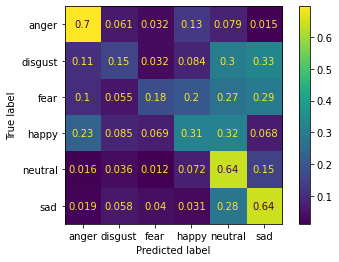

In [52]:
pred = model.predict(X_train)
pred_test = model.predict(X_test)

print("accuracy score for Train set is:", accuracy_score(np.argmax(y_train,axis =1), np.argmax(pred,axis=1)))
print("accuracy score for Test set is: ", accuracy_score(np.argmax(y_test,axis =1), np.argmax(pred_test,axis=1)))
print("[Anger, disgust, fear, happy, neutral, sad]")
print("F1 score for Train set is:", f1_score(np.argmax(y_train,axis =1), np.argmax(pred,axis=1), average = None))
print("F1 score for Test set is: ", f1_score(np.argmax(y_test,axis =1), np.argmax(pred_test,axis=1), average = None))

cm = confusion_matrix(np.argmax(y_test,axis =1), np.argmax(pred_test,axis=1))
cm = cm/ cm.astype(np.float64).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
disp.plot()